In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chatgpt-user-feedback:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5308018%2F8822992%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T085618Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8ad16cb8c2f2c5cd6783d09076611e53a75173b8941014aedba50600571ab8b30543f56eec4fb408cdedf78281e821d77f44c3f7fc309168320f6f35013f240e7013144e78266a8671105e44e02483904867bf5ad6a66e69a3c6241d6415d050d2a1c21ac3d80f2bb7e532f9ed7250ef71e4fef8c3f43dce2329219dab9038b837f4e8beebcc603b3e117d9adbdf91c83102995c689c33017a6d6490d4833492d783e20683ad4671cd3bba4c50f7bfe0c1da13ce98ea2ee1f647d48a81d953b3a87800c1d51f5bdefa5a752e84a61b659e61f95aa365417fa172c45c7b3b6dc2003108766848fcdab31f376cfe4c83f3c5272c9d584b6e4c7a971c46fee2c16b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5709734 bytes downloaded
Downloaded and uncompressed: chatgpt-user-feedback
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import *
from wordcloud import *
from sklearn import *
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import *
from sklearn.tree import *
from sklearn.feature_extraction.text import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import *
from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# Load the dataset
file_path = "/kaggle/input/chatgpt-user-feedback/clean_chatgpt_reviews.csv"
df = pd.read_csv(file_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149719 entries, 0 to 149718
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     149719 non-null  int64 
 1   userName       149719 non-null  object
 2   content        149719 non-null  object
 3   score          149719 non-null  int64 
 4   thumbsUpCount  149719 non-null  int64 
 5   at             149719 non-null  object
dtypes: int64(3), object(3)
memory usage: 6.9+ MB


In [5]:
df.duplicated().value_counts()

,count
False,149719


In [6]:
df.drop_duplicates(inplace=True)
df.shape

(149719, 6)

In [7]:
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head(10)

,userName,content,score,thumbsUpCount,at
0,T H (Trudylh20),excellent Im impressed 👌 👏,5,0,28-06-2024 21:07
1,Muhammad bassam adam,perfect,5,0,28-06-2024 20:56
2,Chinaza Okoli,its been so helpful...love it,5,0,28-06-2024 20:54
3,Project House Group Ltd,It's amazing tools help me a lot with my work.,5,0,28-06-2024 20:51
4,Safoan Riyad,I enjoyed ChatGPT. But last update ruined ever...,1,0,28-06-2024 20:50
5,LEISHA PALLETT,this is the best app I've ever seen!!!,5,0,28-06-2024 20:45
6,M Rizwan,very Nice app,5,0,28-06-2024 20:41
7,Mehdi Hajavi,Your guidance is really great and you can answ...,5,0,28-06-2024 20:39
8,Habimana Therese,This app is very important but sometimes it gi...,4,0,28-06-2024 20:35
9,Xhx Bvj,Absolutely fantastic app. ChatGPT is such a ve...,5,0,28-06-2024 20:29


In [8]:
df.isnull().sum()

,0
userName,0
content,0
score,0
thumbsUpCount,0
at,0


In [9]:
df['time'] = pd.to_datetime(df['at'], format='%d-%m-%Y %H:%M')
df.drop(columns=['at'],inplace=True)
df.head()

,userName,content,score,thumbsUpCount,time
0,T H (Trudylh20),excellent Im impressed 👌 👏,5,0,2024-06-28 21:07:00
1,Muhammad bassam adam,perfect,5,0,2024-06-28 20:56:00
2,Chinaza Okoli,its been so helpful...love it,5,0,2024-06-28 20:54:00
3,Project House Group Ltd,It's amazing tools help me a lot with my work.,5,0,2024-06-28 20:51:00
4,Safoan Riyad,I enjoyed ChatGPT. But last update ruined ever...,1,0,2024-06-28 20:50:00


In [10]:
df[df['thumbsUpCount']==df['thumbsUpCount'].max()]

,userName,content,score,thumbsUpCount,time
38148,Jonathan Lawrence,"it's really brilliant, I mean it's dumb as a b...",5,1193,2023-12-25 17:13:00


In [11]:
def featureScaling(X,a,b):
    X = np.array(X)
    Normalized_X=np.zeros((X.shape[0],X.shape[1]))
    for i in range(X.shape[1]):
        Normalized_X[:,i]=((X[:,i]-min(X[:,i]))/(max(X[:,i])-min(X[:,i])))*(b-a)+a
    return Normalized_X

In [12]:
df['thumbsUpCount']=featureScaling(df[['thumbsUpCount']],0,1)
df.head()

,userName,content,score,thumbsUpCount,time
0,T H (Trudylh20),excellent Im impressed 👌 👏,5,0.0,2024-06-28 21:07:00
1,Muhammad bassam adam,perfect,5,0.0,2024-06-28 20:56:00
2,Chinaza Okoli,its been so helpful...love it,5,0.0,2024-06-28 20:54:00
3,Project House Group Ltd,It's amazing tools help me a lot with my work.,5,0.0,2024-06-28 20:51:00
4,Safoan Riyad,I enjoyed ChatGPT. But last update ruined ever...,1,0.0,2024-06-28 20:50:00


In [13]:
def clean_text(text):
    all_list = [char for char in text if char not in string.punctuation]
    text=''.join(all_list)
    text=text.lower()
    return text

In [14]:
df['content']=df['content'].apply(clean_text)
stop=stopwords.words('english')
df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df.head()

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [15]:
df['score'].value_counts()

,count
score,
5,113738
4,17581
1,9555
3,6256
2,2589


In [16]:
df['class']=df['score'].replace({5:'high',4:'high',3:'mid',2:'low',1:'low'})

In [17]:
df['year'] = df['time'].dt.to_period('Y').astype(str)
df['month'] = df['time'].dt.to_period('M').astype(str)

In [18]:
df.head()

,userName,content,score,thumbsUpCount,time,class,year,month
0,T H (Trudylh20),excellent im impressed 👌 👏,5,0.0,2024-06-28 21:07:00,high,2024,2024-06
1,Muhammad bassam adam,perfect,5,0.0,2024-06-28 20:56:00,high,2024,2024-06
2,Chinaza Okoli,its been so helpfullove it,5,0.0,2024-06-28 20:54:00,high,2024,2024-06
3,Project House Group Ltd,its amazing tools help me a lot with my work,5,0.0,2024-06-28 20:51:00,high,2024,2024-06
4,Safoan Riyad,i enjoyed chatgpt but last update ruined every...,1,0.0,2024-06-28 20:50:00,low,2024,2024-06


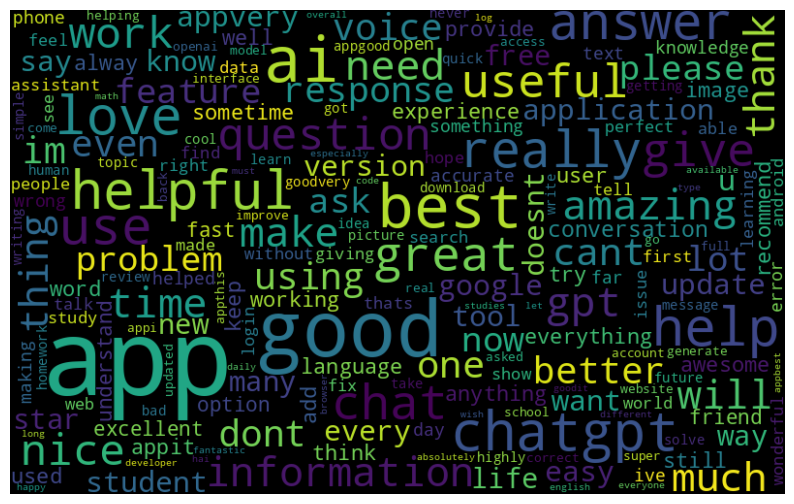

In [19]:
all_words=''.join([word for word in df['content']])
wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

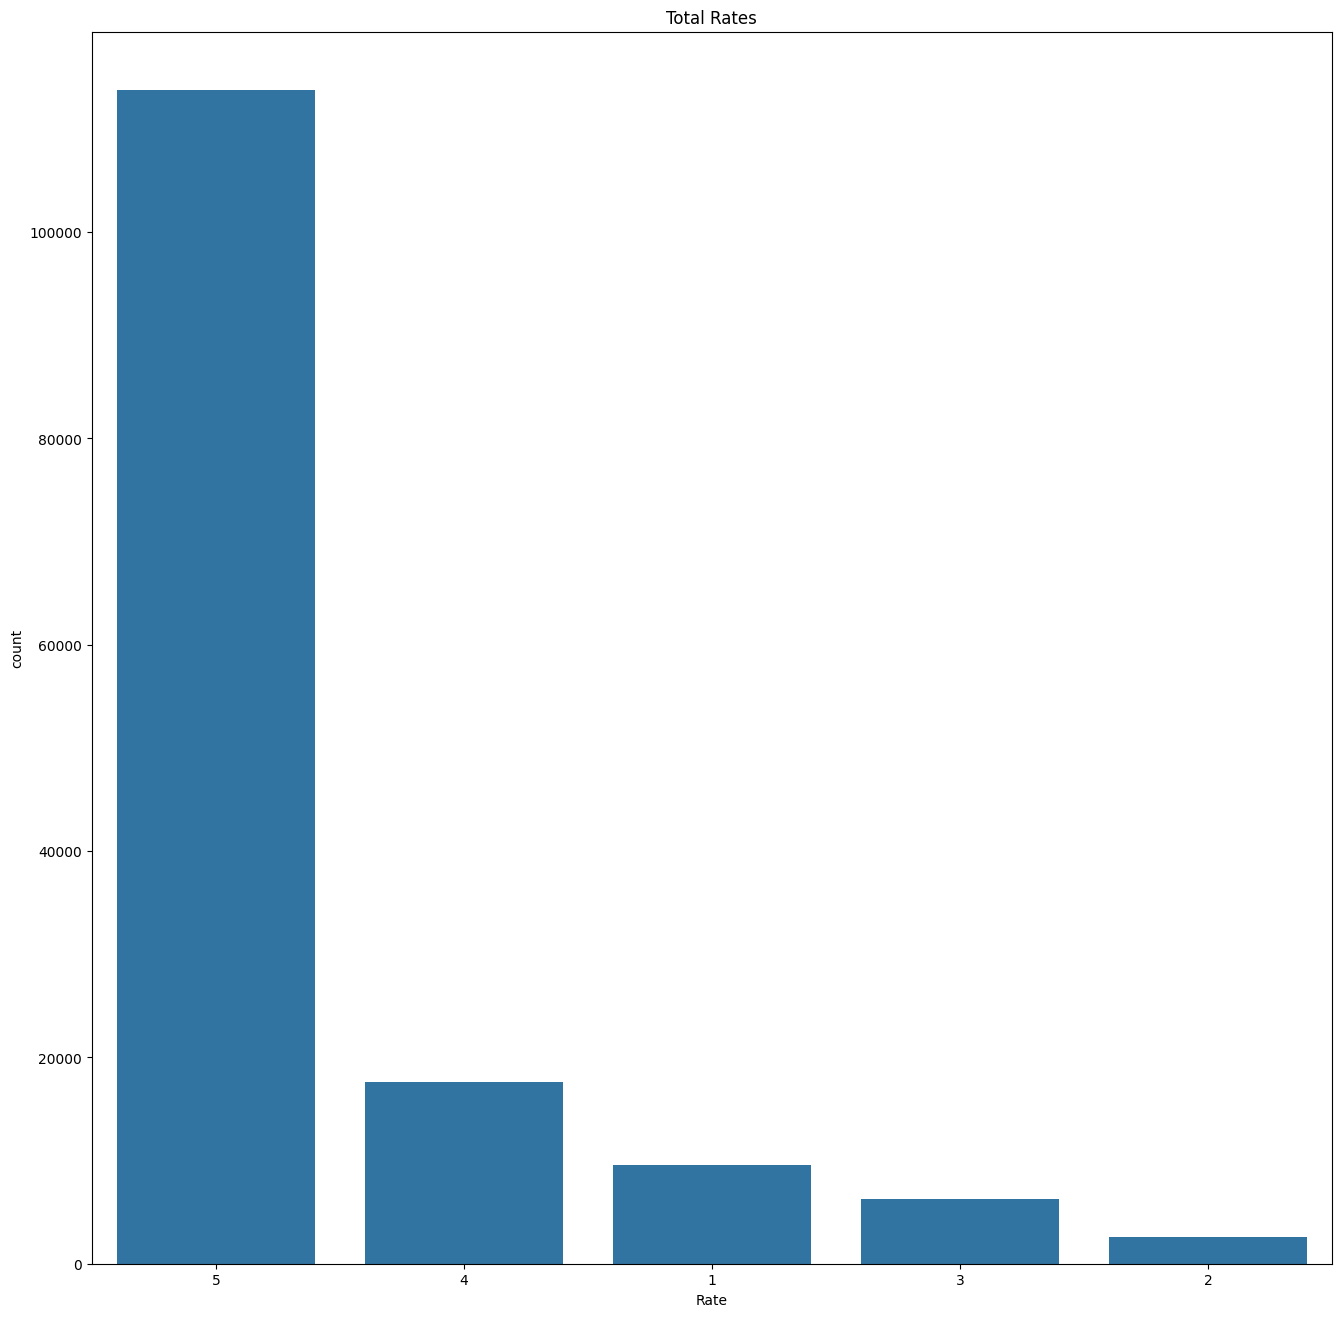

In [20]:
plt.figure(figsize=(16,16))
part_df=df.sort_values('score',ascending=False)
sns.countplot(x=part_df['score'],order=df['score'].value_counts(ascending=False).index)
plt.xlabel('Rate')
plt.title('Total Rates')
plt.show()


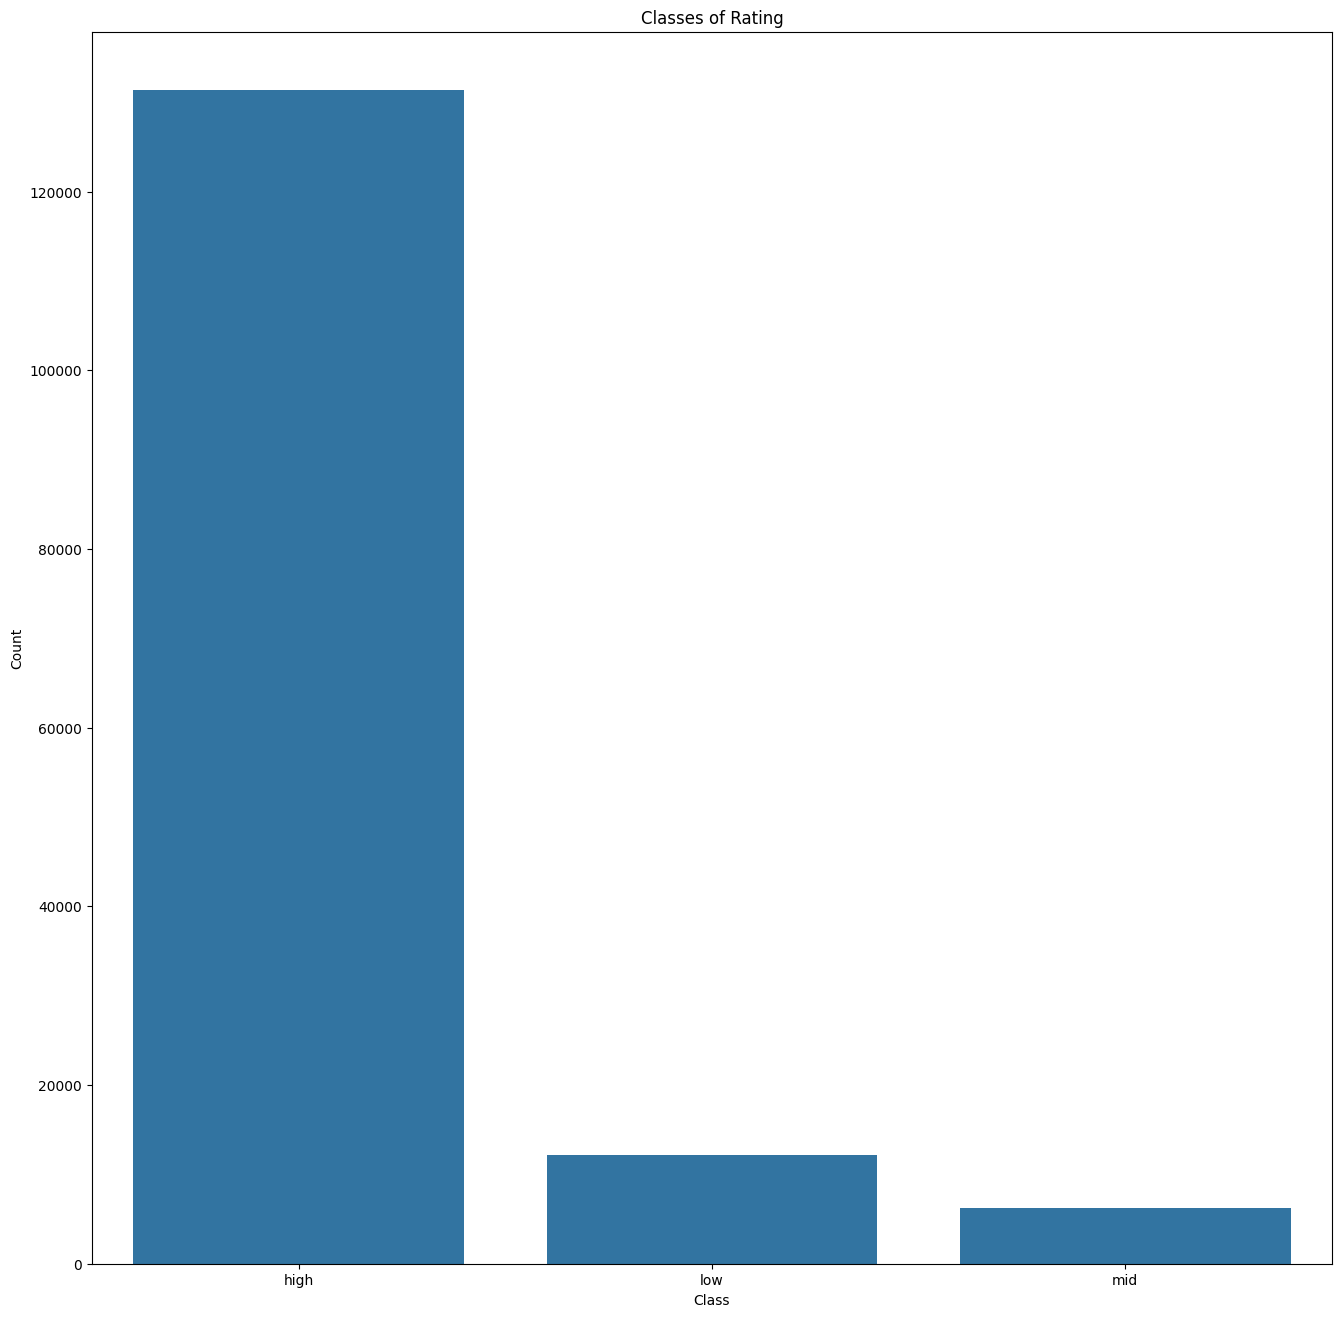

In [21]:
plt.figure(figsize=(16,16))
sns.countplot(x=df['class'])
plt.xlabel('Class');plt.ylabel('Count');plt.title('Classes of Rating')
plt.show()

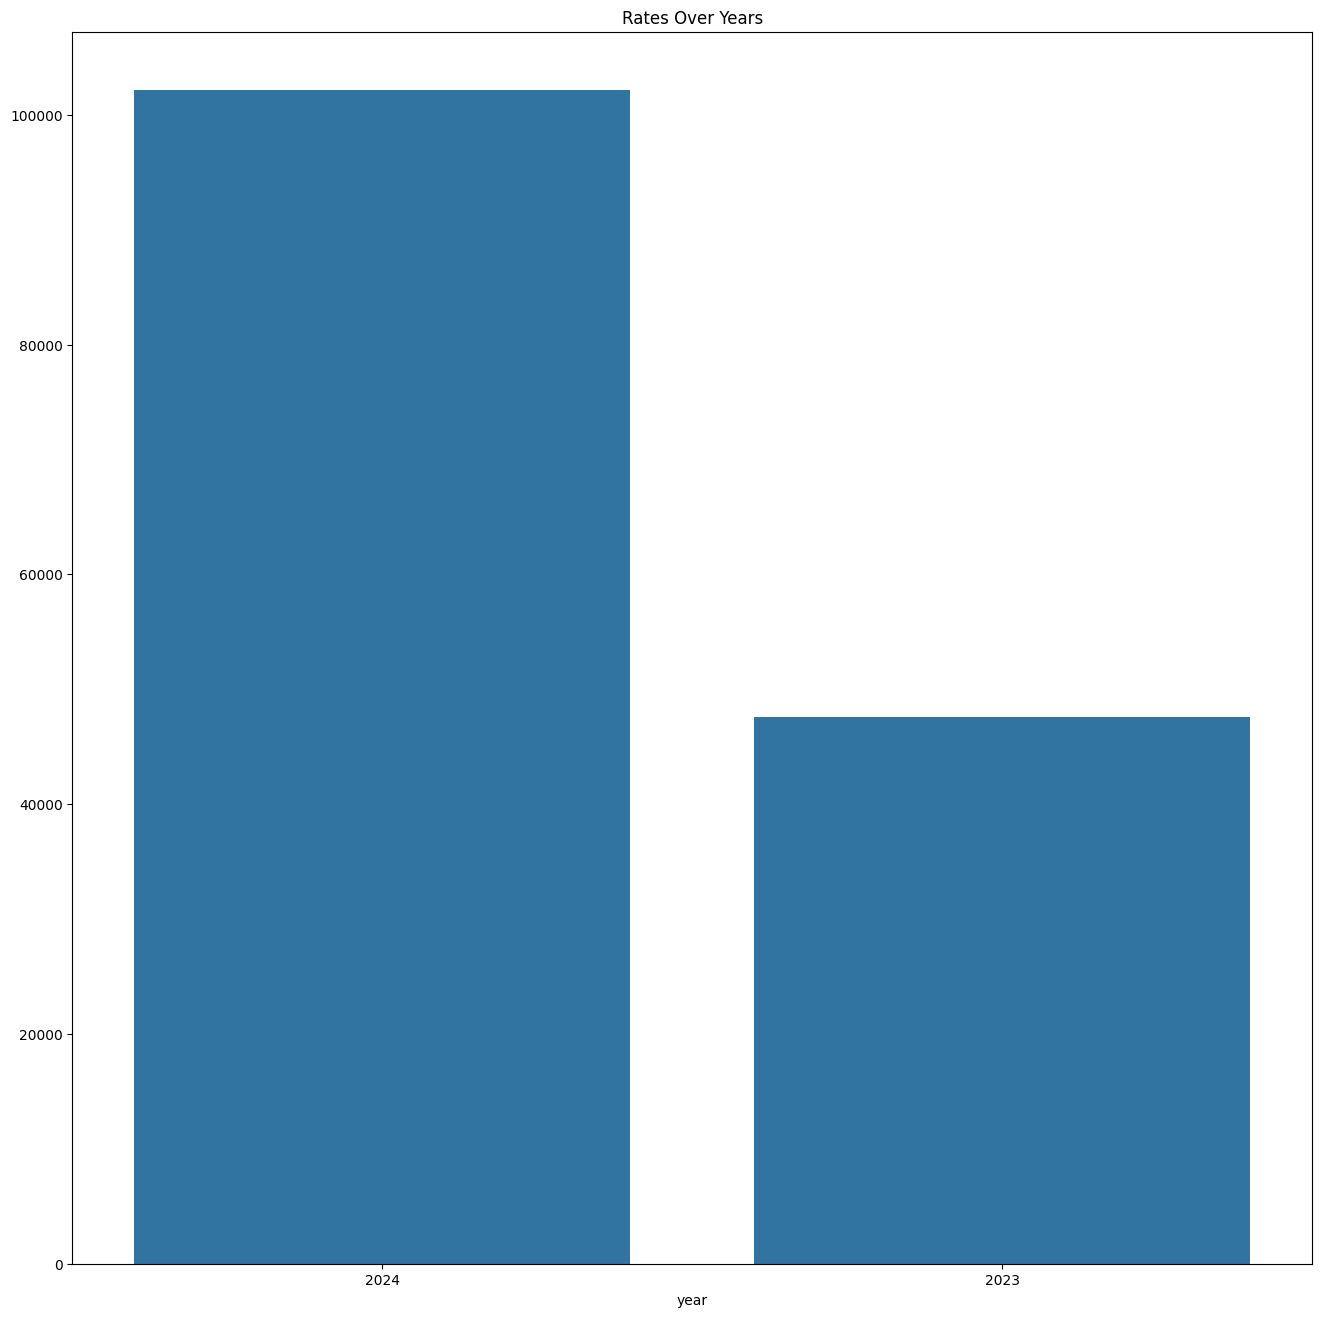

In [22]:
plt.figure(figsize=(16,16))
sns.barplot(x=df['year'].value_counts().index,y=df['year'].value_counts().values)
plt.title('Rates Over Years')
plt.show()


Text(0.5, 1.0, 'Avarge Score over month')

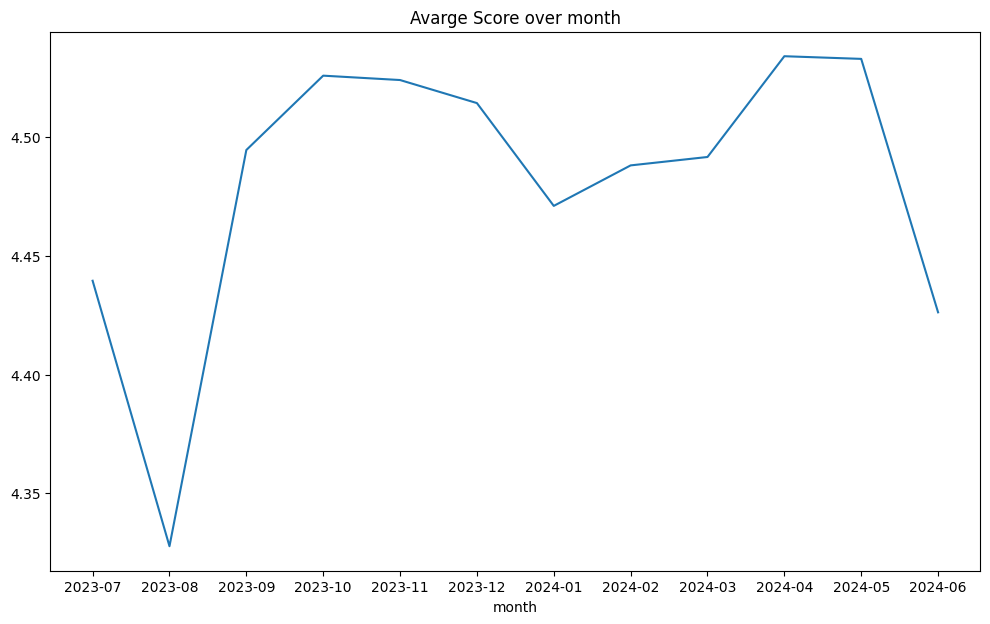

In [23]:
avg_scores=df.groupby('month')['score'].mean()
plt.figure(figsize=(12,7))
sns.lineplot(x=avg_scores.index,y=avg_scores.values)
plt.title('Avarge Score over month')